# Transfer Learning

---

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task.

If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task.

We will consider a large Conv net trained on the [ImageNet data set](http://www.image-net.org/). ImageNet is an image database organized according to the WordNet hierarchy (currently only the nouns), in which each node of the hierarchy is depicted by hundreds and thousands of images. 

![Image Samples](https://adriancolyer.files.wordpress.com/2016/04/imagenet-fig4l.png?w=600)

We will use the [VGG-16](https://arxiv.org/pdf/1409.1556.pdf%20http://arxiv.org/abs/1409.1556.pdf) architecture, which obtains obtains 8.8% error rate.

There are two ways to leverage a pre-trained network: feature extraction and fine-tuning. 

## Feature extraction
---
Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

Convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.

![Feature extraction](https://blogs.rstudio.com/tensorflow/posts/2017-12-14-image-classification-on-small-datasets/images/swapping_fc_classifier.png)

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator

from keras.applications import VGG16

In [2]:
conv_base = VGG16(weights='imagenet', include_top = False, input_shape=(150,150,3))

conv_base.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____

The arguments to the constructor are the following:

- *weights*: specifies which checkpoint go initialize the model from
- *include_top*: whether to include or not the densly-connected classifier
- *input_shape*: the shape of the image tensors

From here we have two options:

1. Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all. 

2. Extending the model we have (conv_base) by adding Dense layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, for this same reason, this technique is far more expensive than the first one.

In [7]:
!git clone https://github.com/DeepLearningVision-2019/Data_sets.git

fatal: destination path 'Data_sets' already exists and is not an empty directory.
Data_sets  sample_data


In [8]:
!ls Data_sets/Dogs_vs_cats/

test_set  training_set


In [11]:
base_dir = 'Data_sets/Dogs_vs_cats/'

train_dir = os.path.join(base_dir, 'training_set')
test_dir = os.path.join(base_dir, 'test_set') 

batch_size = 20

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) 

def extract_features(directory, sample_count, validation = False, test = False): 
    
  features = np.zeros(shape=(sample_count, 4, 4, 512)) 
  labels = np.zeros(shape=(sample_count)) 
  
  subset_string = 'training' if not validation else 'validation'
  
  if not test:
    generator = datagen.flow_from_directory(
      directory, 
      target_size=(150, 150), 
      batch_size=batch_size, 
      class_mode='binary',
      subset=subset_string) 
  else:
    generator = datagen.flow_from_directory(
      directory, 
      target_size=(150, 150), 
      batch_size=batch_size, 
      class_mode='binary') 
  
  i = 0 
  
  for inputs_batch, labels_batch in generator: 
    features_batch = conv_base.predict(inputs_batch) 
    features[i * batch_size : (i + 1) * batch_size] = features_batch 
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch 
    i += 1 
    
    if i * batch_size >= sample_count: 
      # Note that since generators yield data indefinitely in a loop, 
      # we must `break` after every image has been seen once. 
      break 
 
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000) 
validation_features, validation_labels = extract_features(train_dir, 1000) 
test_features, test_labels = extract_features(test_dir, 1000)

Found 6400 images belonging to 2 classes.
Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


In [13]:
print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

# Since we are going to feed the predictions to a dense layer, we need to flatten the inputs

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

(2000, 4, 4, 512)
(1000, 4, 4, 512)
(1000, 4, 4, 512)
(2000, 8192)
(1000, 8192)
(1000, 8192)


In [14]:
# We define a model for the dense layers

model = models.Sequential() 
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512)) 
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(1, activation='sigmoid')) 

model.summary()

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.5881 - acc: 0.6865 - val_loss: 0.4495 - val_acc: 0.8220
Epoch 2/30
2000/2000 [==============================] - 1s 726us/step - loss: 0.4266 - acc: 0.8095 - val_loss: 0.3615 - val_acc: 0.8590
Epoch 3/30
2000/2000 [==============================] - 1s 692us/step - loss: 0.3659 - acc: 0.8440 - val_loss: 0.3300 - val_acc: 0.8750
Epoch 4/30
2000/2000 [==============================] - 1s 604us/step - loss: 0.3197 - acc: 0.8610 - val_loss: 0.2981 - val_acc: 0.8690
Epoch 5/30
2000/2000 [==============================] - 1s 652us/step - loss: 0.2992 - acc: 0.8775 - val_loss: 0.2796 - val_acc: 0.8840
Epoch 6/30
2000/2000 [==============================] - 1s 635us/step - loss: 0.2799 - acc: 0.8870 - val_loss: 0.2642 - val_acc: 0.8940
Epoch 7/30
2000/2000 [==============================] - 1s 621us/step - loss: 0.2581 - acc

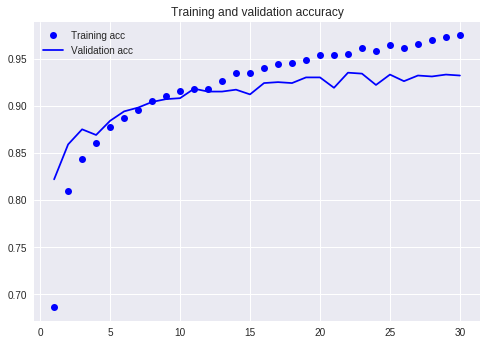

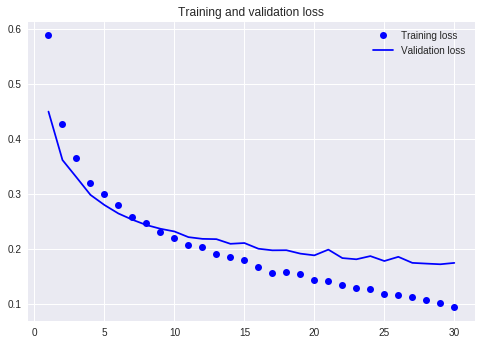

In [17]:
acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(1, len(acc) + 1) 

plt.plot(epochs, acc, 'bo', label='Training acc') 

plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 

plt.figure() 
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()
plt.show()

You can use model.save(filepath) to save a Keras model into a single HDF5 file which will contain:

- the architecture of the model, allowing to re-create the model
- the weights of the model
- the training configuration (loss, optimizer)
- the state of the optimizer, allowing to resume training exactly where you left off.

If you need to save the weights of a model, you can do so in HDF5 with: *model.save_weights*:

In [0]:
model.save('feature_extraction.model.hdf5')
model.save_weights('feature_extraction.weights.hdf5')

In [37]:
from google.colab import files

!ls
files.download( "feature_extraction.model.hdf5" ) 
files.download( "feature_extraction.weights.hdf5" ) 
files.download( "fine_tuning.model.hdf5" ) 
files.download( "fine_tuning.weights.hdf5" ) 

Data_sets			 fine_tuning.model.hdf5
feature_extraction.model.hdf5	 fine_tuning.weights.hdf5
feature_extraction.weights.hdf5  sample_data


Another option to use feature extraction would be to retrain the whole network with data augmentation to avoid the overfitting that started at around epoch 10. This technique is slower and more expensive, however. It consists on extending the *conv_base* model and running it end to end on the inputs. **Do not use without a GPU.**



In [18]:
# Because models behave just like layers, you can add a model (like our conv_base) to a 
#Sequential model just like you would add a layer. 

model_extended = models.Sequential() 
model_extended.add(conv_base) 
model_extended.add(layers.Flatten()) 
model_extended.add(layers.Dense(256, activation='relu')) 
model_extended.add(layers.Dense(1, activation='sigmoid'))

model_extended.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of layers means preventing their weights from getting updated during training. If we don’t do this, then the representations that were previously learned by the convolutional base would get modified during training.

In [0]:
conv_base.trainable = False

## Fine tuning
---

Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning. Fine-tuning consists in unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

![Fine tuning](https://blog.keras.io/img/imgclf/vgg16_modified.png)

In [22]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

We will fine-tune the last 3 convolutional layers, which means that all layers up until block4_pool should be frozen, and the layers block5_conv1, block5_conv2 and block5_conv3 should be trainable. Why not fine-tune more layers? 

We need to consider that: 
- Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. 
- There would be fast-decreasing returns in fine-tuning lower layers. 
- The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be risky to attempt to train it on our small dataset.

In [0]:
conv_base.trainable = True
set_trainable = False 

for layer in conv_base.layers: 
  if layer.name == 'block5_conv1': 
    set_trainable = True 
    
  if set_trainable: 
    layer.trainable = True 
  else: layer.trainable = False

In [29]:
train_datagen = ImageDataGenerator( rescale=1./255, 
                                   rotation_range=40,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory( 
    train_dir,
    target_size=(150, 150), 
    batch_size=20, 
    class_mode='binary') 

validation_generator = test_datagen.flow_from_directory( 
    test_dir, 
    target_size=(150, 150),
    batch_size=20, 
    subset='training',
    class_mode='binary') 

test_generator = test_datagen.flow_from_directory( 
    test_dir, 
    target_size=(150, 150),
    batch_size=20, 
    subset='validation',
    class_mode='binary') 

model_extended.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

history = model_extended.fit_generator( train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50)


Found 8000 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 47s 465ms/step - loss: 0.3810 - acc: 0.8365 - val_loss: 0.2472 - val_acc: 0.8930
Epoch 2/30
100/100 [==============================] - 42s 422ms/step - loss: 0.3404 - acc: 0.8475 - val_loss: 0.2405 - val_acc: 0.8930
Epoch 3/30
100/100 [==============================] - 41s 407ms/step - loss: 0.3188 - acc: 0.8565 - val_loss: 0.3048 - val_acc: 0.8790
Epoch 4/30
100/100 [==============================] - 43s 435ms/step - loss: 0.2876 - acc: 0.8815 - val_loss: 0.2317 - val_acc: 0.8970
Epoch 5/30
100/100 [==============================] - 43s 431ms/step - loss: 0.2705 - acc: 0.8810 - val_loss: 0.1684 - val_acc: 0.9260
Epoch 6/30
100/100 [==============================] - 44s 437ms/step - loss: 0.2473 - acc: 0.8985 - val_loss: 0.2064 - val_acc: 0.9190
Epoch 7/30
100/100 [==============================] - 43s 433ms/s

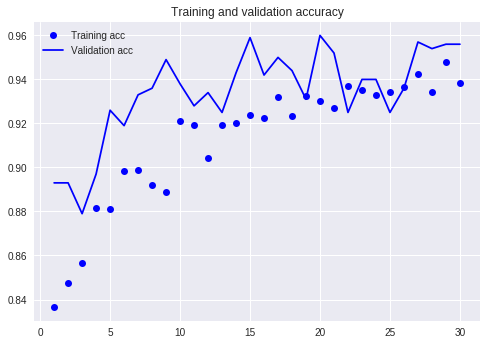

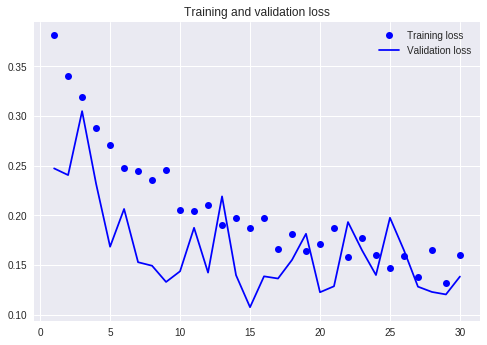

In [30]:
acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(1, len(acc) + 1) 

plt.plot(epochs, acc, 'bo', label='Training acc') 

plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 

plt.figure() 
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()
plt.show()

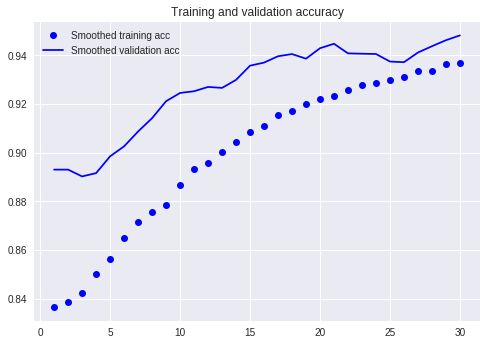

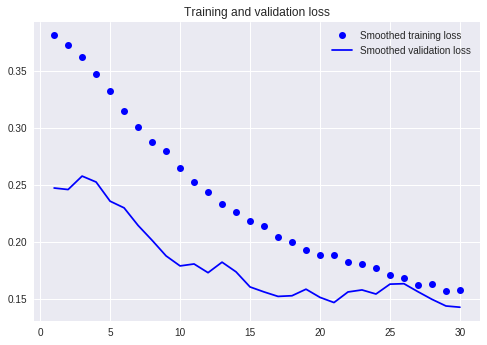

In [31]:
def smooth_curve(points, factor=0.8): 
  smoothed_points = [] 
  for point in points: 
    if smoothed_points: 
      previous = smoothed_points[-1] 
      smoothed_points.append(previous * factor + point * (1 - factor)) 
    else: 
      smoothed_points.append(point) 
  
  return smoothed_points 

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc') 
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure() 
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss') 
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss') 
plt.title('Training and validation loss') 
plt.legend() 
plt.show()

In [0]:
model_extended.save('fine_tuning.model.hdf5')
model_extended.save_weights('fine_tuning.weights.hdf5')